In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
import datetime as dt

import folium
from folium.plugins import HeatMap
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import plotly.express as px

from scipy.interpolate import griddata
from numpy import linspace

In [2]:
matplotlib.rc_file_defaults()

In [3]:
# reading in data 

incident_report = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present.csv')
reference_codes = pd.read_csv('Reference__Police_Department_Incident_Code_Crosswalk_with_ucr.csv')

# rename reference code column to merge 

reference_codes.rename(columns = {'INC_CODE':'Incident Code'}, inplace = True)

# merge dataframes; 460432 rows and 39 columns

incident_report = incident_report.merge(reference_codes, on = 'Incident Code', how = 'left', indicator = True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', False)

In [4]:
# incident_report.info()

In [5]:
incident_report['_merge'].value_counts(dropna = False)

both          460073
left_only        359
right_only         0
Name: _merge, dtype: int64

In [6]:
# 685 codes that do not have corresponding UCR category

reference_codes.loc[reference_codes['UCR_part_1'].isna(), 'Incident Code'].value_counts(dropna = False);

In [7]:
reference_codes.loc[reference_codes['UCR_part_1'].notna()];

# Pre-processing

In [8]:
# dropping columns

incident_report.drop(columns = ['Incident Datetime','Supervisor District', 'Current Supervisor Districts'], inplace = True)

In [9]:
# function to filter out unwanted categories

def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values) == False]

In [10]:
# updated has 246439 rows and 36 columns

incident_report = filter_rows_by_values(incident_report, 'Incident Category', ['Case Closure','Civil Sidewalks','Courtesy Report',
                              'Fire Report','Lost Property','Missing Person','Non-Criminal',
                              'Other','Recovered Vehicle','Suicide','Suspicious','Suspicious Occ',
                              'Traffic Collision','Vehicle Impounded','Vehicle Misplaced','Warrant', 'Liquor Laws', 'Gambling',
                            'Malicious Mischief', 'Other Miscellaneous','Fraud', 'Disorderly Conduct', 'Miscellaneous Investigation',
                                'Other Offenses', 'Traffic Violation Arrest', 'Weapons Offense', 'Forgery and Counterfeiting', 'Weapons Carrying Etc',
                                'Stolen Property', 'Prostitution', 'Embezzlement', 'Vandalism', 'Sex Offense'])

In [11]:
# convert to datetime ; data starts at 2018-01-01 and ends at 2021-07-20

incident_report['Incident Date'] = pd.to_datetime(incident_report['Incident Date'])

In [12]:
# omitting entries later than June 30, 2021 because latest date is 07-20-2021
# 243098 rows and 37 columns

incident_report = incident_report[incident_report['Incident Date'] <= '2021-06-30']

In [13]:
# extracting months variable

incident_report['Months']=incident_report['Incident Date'].dt.month

In [14]:
# changing to month digits to full month names 

months_dict = {1:'January', 2:'February', 3:'March', 4:'April',5:'May', 6:'June', 
           7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

incident_report['Months'].replace(months_dict, inplace = True)

In [15]:
# dropping duplicates and keeping only the highest crime category based on UCR hierarchy 
# 228879 rows and 37 columns

incident_report = incident_report.sort_values('UCR_part_1_code').drop_duplicates('Incident ID', keep = 'first')

In [16]:
# variable to see whether there is a CAD number or not
# 228879 rows and 38 columns

incident_report['Binary CAD'] = incident_report['CAD Number'].notnull()*1

In [17]:
# adding geometric variable

geometry = [Point(xy) for xy in zip(incident_report['Longitude'], incident_report['Latitude'])]
incident_report = gpd.GeoDataFrame(incident_report, geometry = geometry)

# Total Incidents

In [18]:
# graphing totals over time

def total_graph(df, title):
    monthly_counts = (
    df[["Incident Year", "Months", "Incident ID"]]
    .groupby(["Incident Year", "Months"])
    .agg(incident_count=("Incident ID", "count"))
    .reset_index()
    )
    monthly_counts["ym"] = pd.to_datetime(
    monthly_counts["Months"]
    + " "
    + "01"
    + ", "
    + monthly_counts["Incident Year"].astype(str),
    format="%B %d, %Y",
    )
    monthly_counts = monthly_counts.sort_values("ym")
    monthly_counts = monthly_counts.loc[(monthly_counts["ym"] > "2019-02-01")]
    ax = sns.lineplot(data=monthly_counts, x="ym", y="incident_count")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.axvline(pd.to_datetime("2020-03-01"), color = 'red', linewidth = .8, linestyle = '--')
    plt.xticks(rotation=90)
    ax.set_title(title)
    plt.xlabel('')
    plt.ylabel('Incident Count')
    plt.show()

In [19]:
# function to filter wanted categories

def filter_inrows_by_values(df, col, values):
    return df[df[col].isin(values) == True]

In [20]:
# total_incidents1 - with 8 UCR categories - reduces the dataset to 195028 rows

total_incidents1 = filter_inrows_by_values(incident_report, 'UCR_part_1', ['aggravated assault', 'rape',
                                                                        'homicide ', 'robbery', 'burglary ', 
                                                                        'arson', 'larceny theft','motor vehicle theft'])
total_incidents = pd.pivot_table(total_incidents1, index = 'Months', columns = 'Incident Year', values = 'Incident ID', aggfunc = 'size')
total_incidents = total_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_incidents 

Incident Year    2018    2019    2020    2021
Months                                       
January        5860.0  4889.0  5522.0  3461.0
February       4831.0  4482.0  4799.0  3690.0
March          5075.0  4811.0  3791.0  3706.0
April          5086.0  4669.0  3214.0  3808.0
May            5379.0  5076.0  3167.0  4834.0
June           5424.0  5159.0  2808.0  4702.0
July           6189.0  5795.0  3122.0     NaN
August         6094.0  6075.0  3047.0     NaN
September      5461.0  5629.0  2588.0     NaN
October        5582.0  6188.0  2939.0     NaN
November       5048.0  5379.0  3165.0     NaN
December       5458.0  5671.0  3355.0     NaN

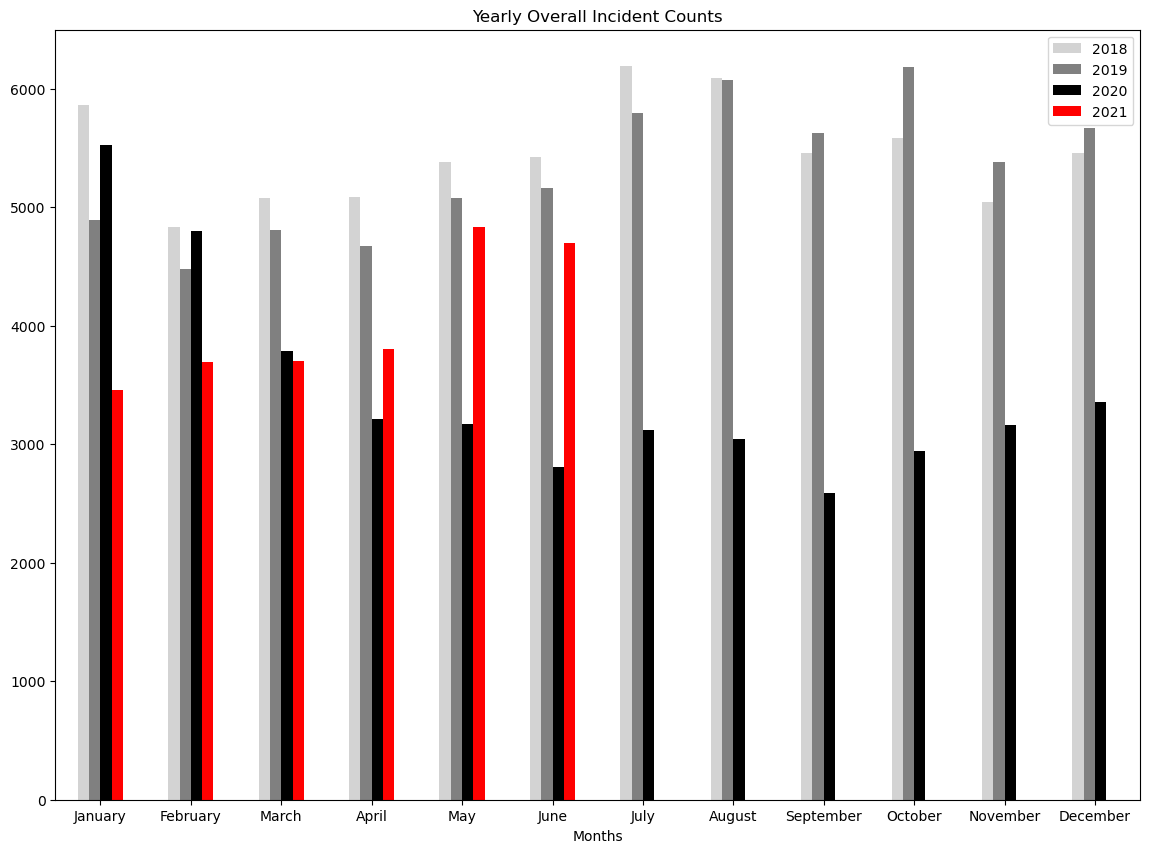

In [21]:
total_incidents.plot(kind = 'bar', figsize = (14,10), color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Incident Counts')
plt.legend(loc = 'best');

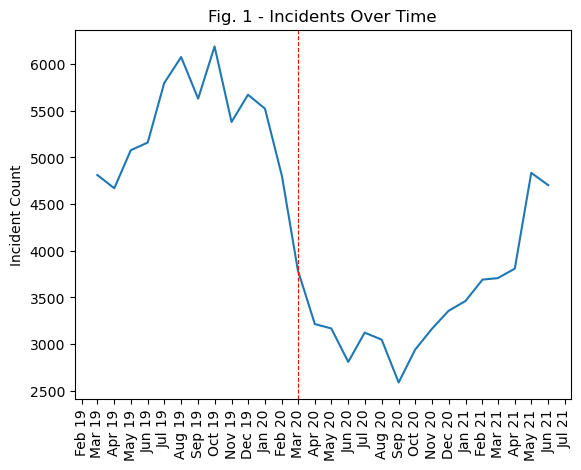

In [22]:
total_graph(total_incidents1, 'Fig. 1 - Incidents Over Time')

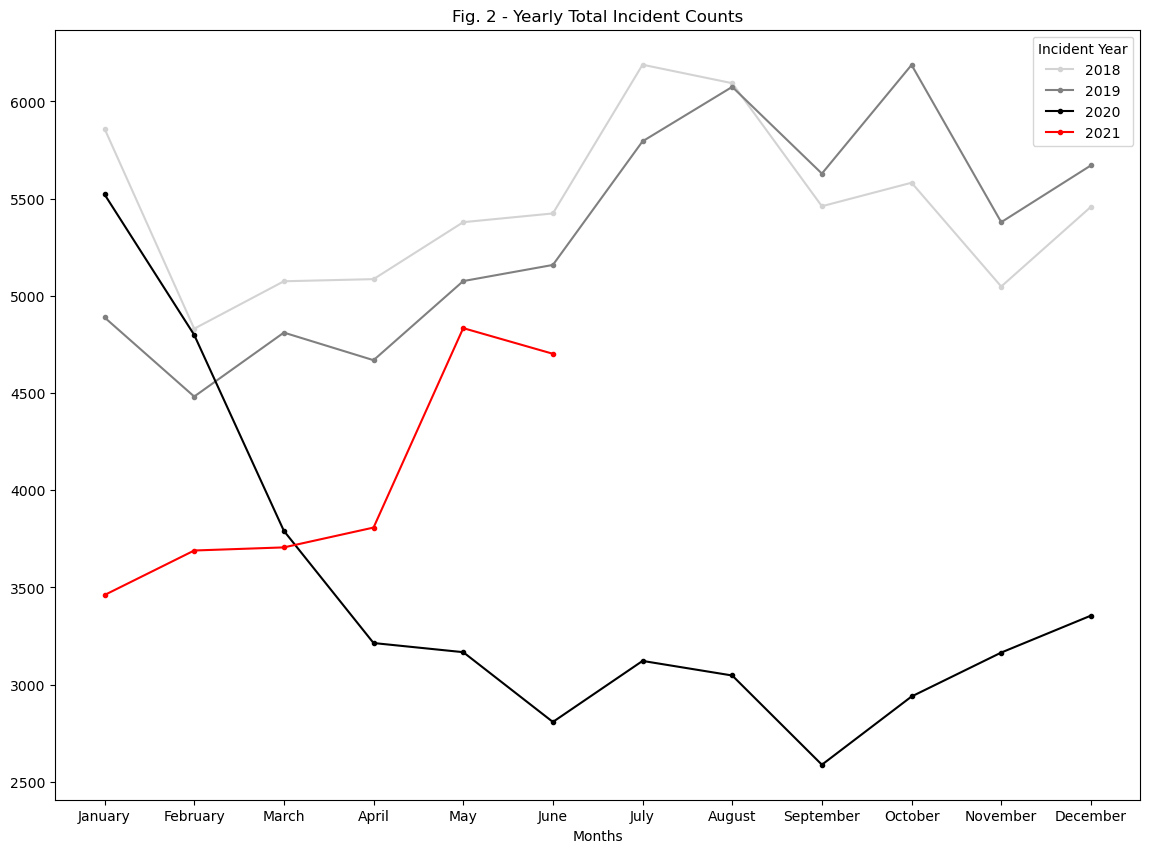

In [23]:
line = total_incidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
line.set_xticks(np.arange(0,12))
line.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
line.set_title('Fig. 2 - Yearly Total Incident Counts');

# Violent Incidents 

In [24]:
# violent crime visualization 
# (19061, 39) using UCR categories

violentincidents = filter_inrows_by_values(total_incidents1, 'UCR_part_1', ['aggravated assault', 'rape',
                                                                           'homicide ', 'robbery'])

In [25]:
violent_incidents = pd.pivot_table(violentincidents, index = 'Months', columns = 'Incident Year', values = 'UCR_part_1', aggfunc = 'size')
total_violentincidents = violent_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_violentincidents

Incident Year   2018   2019   2020   2021
Months                                   
January        492.0  460.0  461.0  353.0
February       536.0  373.0  518.0  435.0
March          507.0  494.0  444.0  375.0
April          471.0  462.0  319.0  385.0
May            548.0  508.0  305.0  439.0
June           581.0  498.0  274.0  439.0
July           579.0  503.0  298.0    NaN
August         545.0  590.0  287.0    NaN
September      497.0  504.0  302.0    NaN
October        496.0  587.0  350.0    NaN
November       467.0  573.0  355.0    NaN
December       560.0  495.0  396.0    NaN

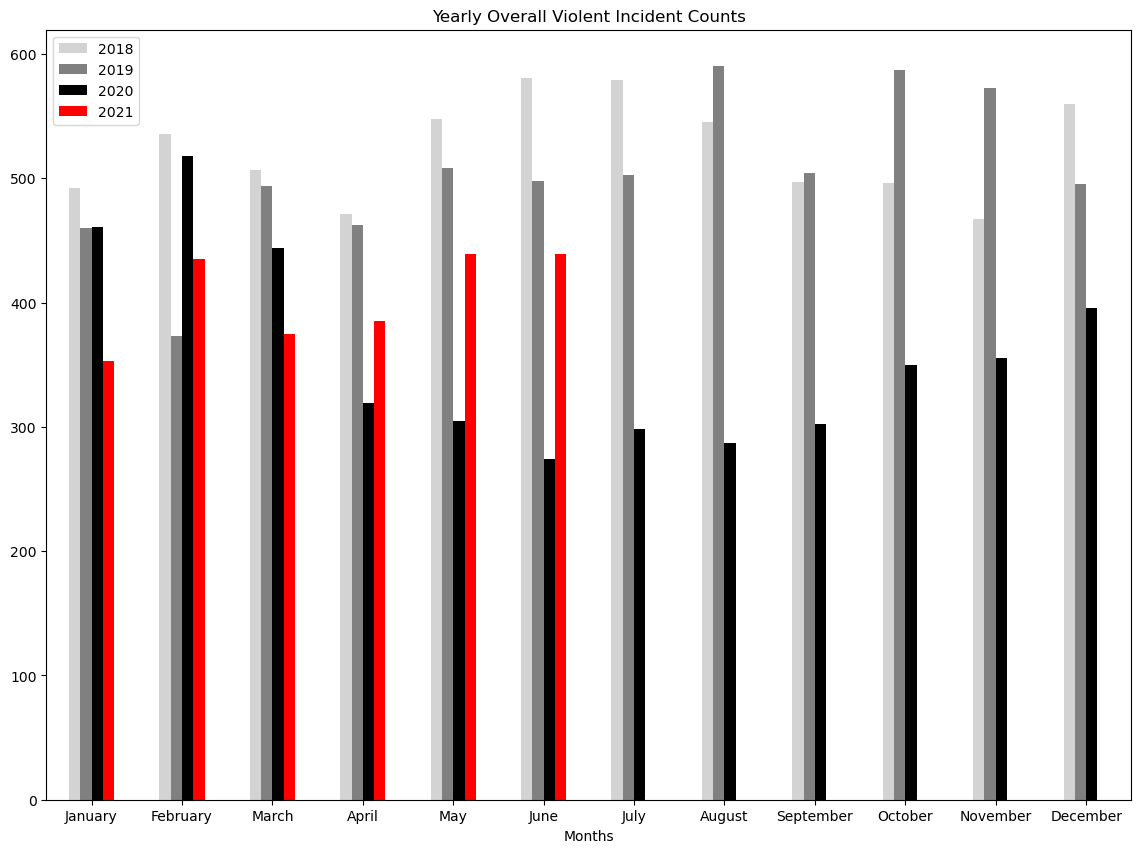

In [26]:
total_violentincidents.plot(kind = 'bar', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Violent Incident Counts')
plt.legend(loc = 'best');

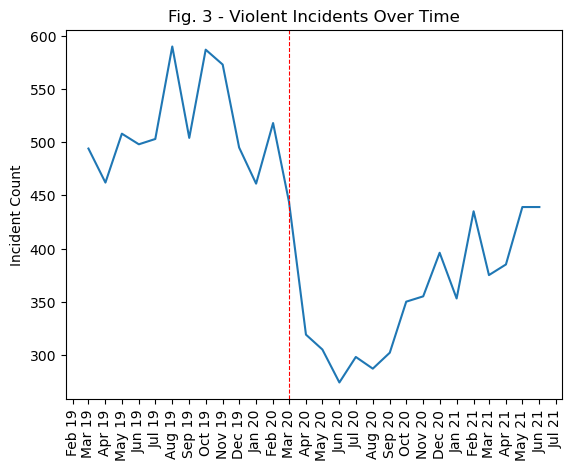

In [27]:
total_graph(violentincidents, 'Fig. 3 - Violent Incidents Over Time')

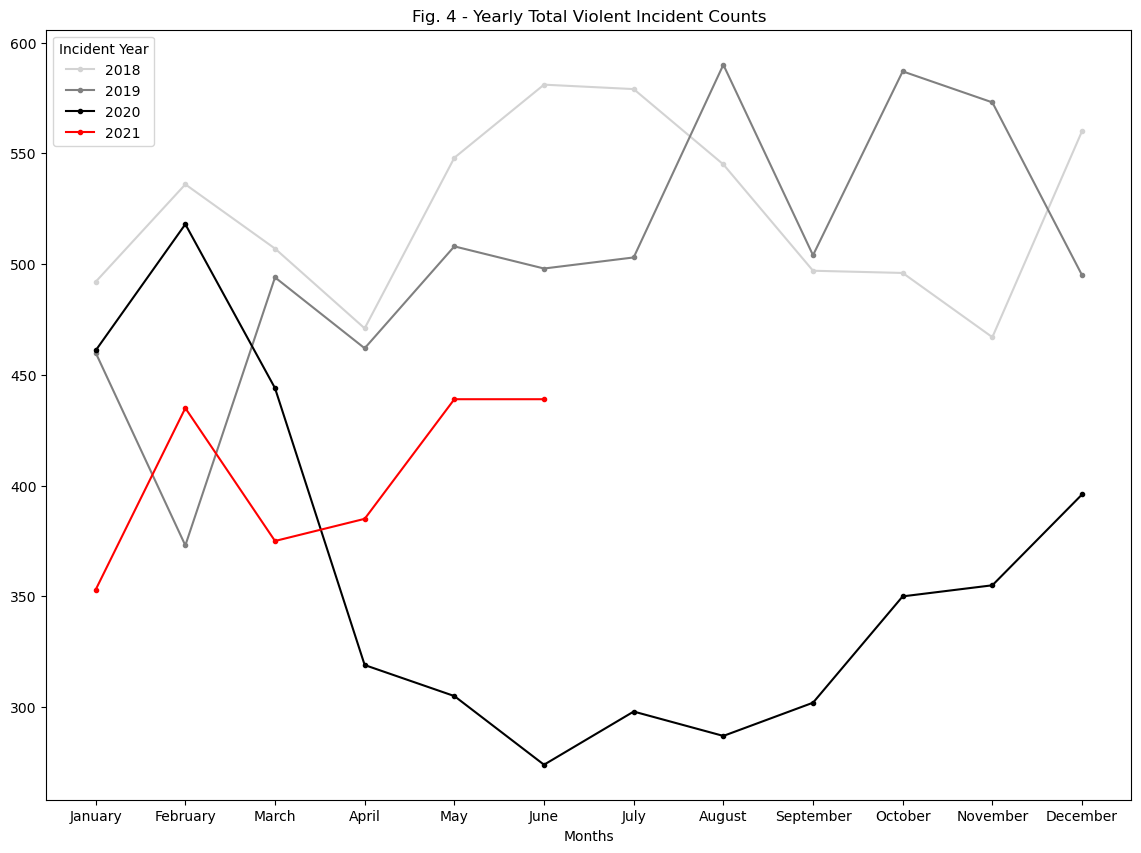

In [28]:
violentline = total_violentincidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
violentline.set_xticks(np.arange(0,12))
violentline.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
violentline.set_title('Fig. 4 - Yearly Total Violent Incident Counts');

In [29]:
# incidents (month/year)

def incident_agg(df):
    table = pd.pivot_table(
    df, 
    index = ['UCR_part_1', 'Months'], 
    columns = ['Incident Year'], 
    values = 'Incident ID', 
    aggfunc = 'size').reindex(
    ['January', 'February', 'March', 'April', 'May', 
     'June', 'July', 'August', 'September', 'October', 
     'November', 'December'], 
    axis=0, level=1)
    
    pd.set_option('display.max_rows', None)
    return table

In [30]:
# graph incidents

def incident_graph(df, itype, title):
        df = df[df['UCR_part_1'] == itype]
        table = pd.pivot_table(
            df,
            index = 'Months', 
            columns = 'Incident Year', 
            values = 'Incident ID', 
            aggfunc = 'size').reindex(
            index = ['January', 'February', 'March', 'April', 'May', 
                    'June', 'July', 'August', 'September', 'October', 'November', 
                    'December']) 
        plot = table.plot(
            kind = 'line', 
            figsize = (14,10),
            color = ['lightgray', 'gray', 'black', 'red'], 
            marker = '.',
            rot = 0)
        plot.set_xticks(np.arange(0,12))
        plot.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
        plot.set_title(title)

In [31]:
incident_agg(violentincidents)

Incident Year                  2018   2019   2020   2021
UCR_part_1         Months                               
aggravated assault January    212.0  164.0  163.0  175.0
                   February   222.0  140.0  185.0  175.0
                   March      217.0  240.0  184.0  178.0
                   April      228.0  203.0  151.0  207.0
                   May        239.0  249.0  164.0  240.0
                   June       256.0  221.0  133.0  226.0
                   July       227.0  240.0  139.0    NaN
                   August     239.0  270.0  134.0    NaN
                   September  191.0  215.0  169.0    NaN
                   October    208.0  228.0  205.0    NaN
                   November   193.0  201.0  178.0    NaN
                   December   198.0  206.0  179.0    NaN
homicide           January      1.0    1.0    NaN    1.0
                   February     NaN    NaN    2.0    2.0
                   March        1.0    1.0    NaN    1.0
                   April        1.0    1.0    NaN    NaN
                   May          2.0    2.0    1.0    1.0
                   June         1.0    4.0    NaN    NaN
                   August       8.0    1.0    NaN    NaN
                   September    1.0    NaN    1.0    NaN
                   October      2.0    3.0    NaN    NaN
                   November     2.0    2.0    NaN    NaN
                   December     5.0    NaN    4.0    NaN
rape               January      2.0    7.0    4.0    1.0
                   February     3.0    3.0    2.0    1.0
                   March        2.0    2.0    1.0    3.0
                   April        3.0    1.0    NaN    1.0
                   May          1.0    3.0    2.0    NaN
                   June         5.0    3.0    2.0    3.0
                   July         6.0    4.0    2.0    NaN
                   August       7.0    1.0    1.0    NaN
                   September    4.0    1.0    NaN    NaN
                   October      4.0    2.0    2.0    NaN
                   November     1.0    4.0    2.0    NaN
                   December     1.0    5.0    NaN    NaN
robbery            January    277.0  288.0  294.0  176.0
                   February   311.0  230.0  329.0  257.0
                   March      287.0  251.0  259.0  193.0
                   April      239.0  257.0  168.0  177.0
                   May        306.0  254.0  138.0  198.0
                   June       319.0  270.0  139.0  210.0
                   July       346.0  259.0  157.0    NaN
                   August     291.0  318.0  152.0    NaN
                   September  301.0  288.0  132.0    NaN
                   October    282.0  354.0  143.0    NaN
                   November   271.0  366.0  175.0    NaN
                   December   356.0  284.0  213.0    NaN

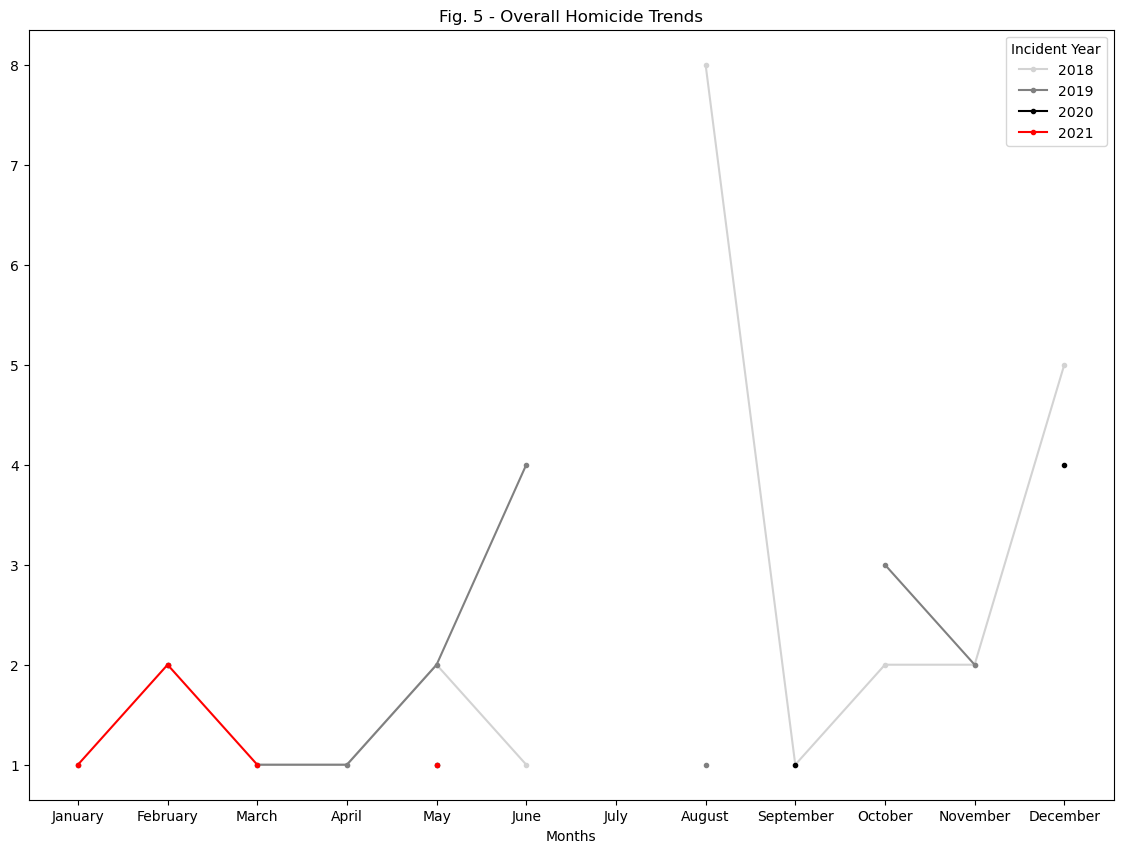

In [32]:
# homicide trends

incident_graph(violentincidents, 'homicide ', 'Fig. 5 - Overall Homicide Trends')

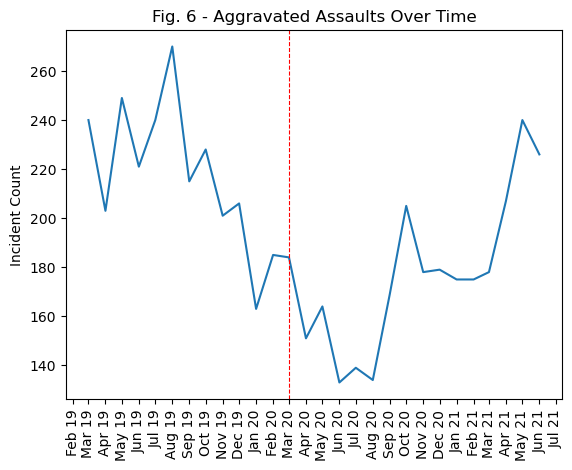

In [33]:
agg_subset = total_incidents1[total_incidents1['UCR_part_1'] == 'aggravated assault']

total_graph(agg_subset, 'Fig. 6 - Aggravated Assaults Over Time')

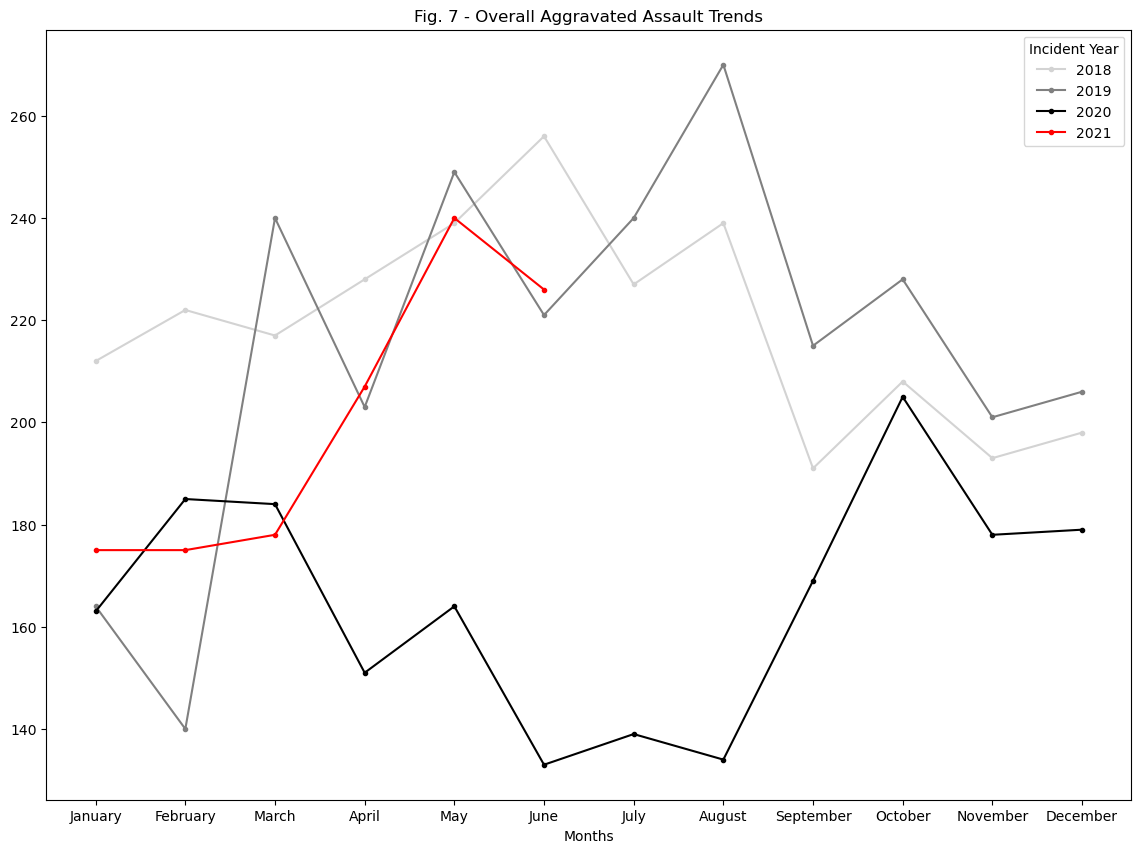

In [34]:
# aggravated assault trends

incident_graph(violentincidents, 'aggravated assault', 'Fig. 7 - Overall Aggravated Assault Trends')

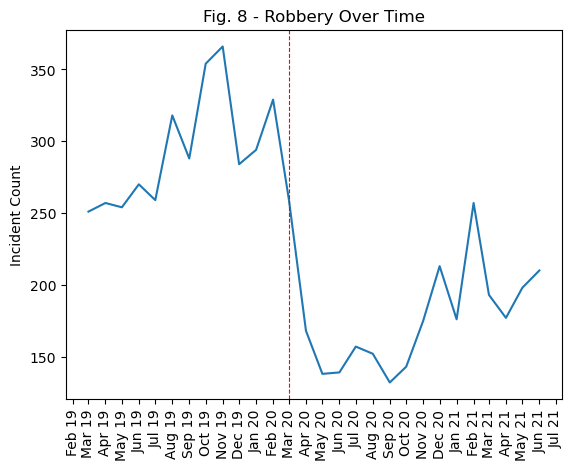

In [35]:
robbery_subset = total_incidents1[total_incidents1['UCR_part_1'] == 'robbery']

total_graph(robbery_subset, 'Fig. 8 - Robbery Over Time')

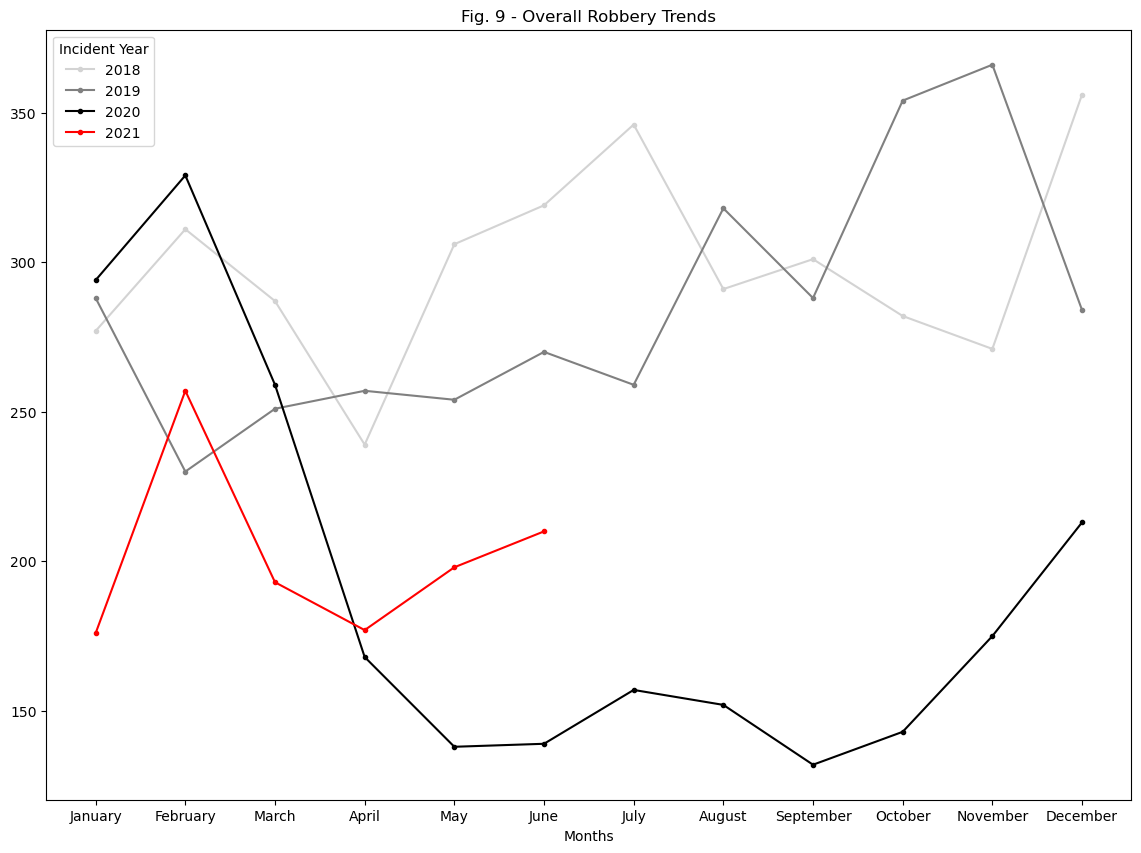

In [36]:
# robbery trends 

incident_graph(violentincidents, 'robbery', 'Fig. 9 - Overall Robbery Trends')

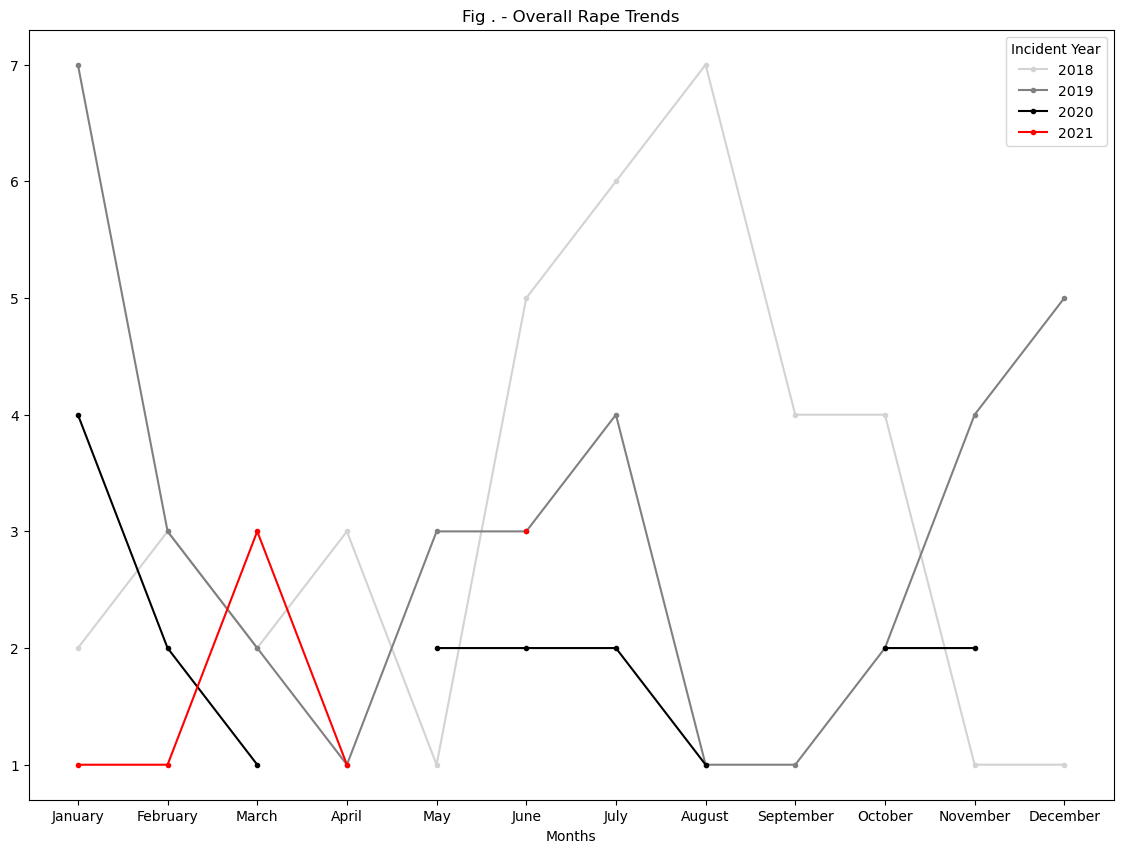

In [37]:
# rape trends

incident_graph(violentincidents, 'rape', 'Fig . - Overall Rape Trends')

In [38]:
#pd.DataFrame(prepostviolent.groupby(['UCR_part_1', 'Incident Year','Months']).agg('size'))

# Property Incidents

In [39]:
# property crime visualization
# 175967 with UCR incident hierarchy

propertyincidents = filter_inrows_by_values(total_incidents1, 'UCR_part_1', ['burglary ', 'arson', 'larceny theft',
                                                                         'motor vehicle theft'])


In [40]:
property_incidents = pd.pivot_table(propertyincidents, index = 'Months', columns = 'Incident Year', values = 'UCR_part_1', aggfunc = 'size')
total_propertyincidents = property_incidents.reindex(index = ['January', 'February', 'March', 'April', 'May', 
                                 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
total_propertyincidents

Incident Year    2018    2019    2020    2021
Months                                       
January        5368.0  4429.0  5061.0  3108.0
February       4295.0  4109.0  4281.0  3255.0
March          4568.0  4317.0  3347.0  3331.0
April          4615.0  4207.0  2895.0  3423.0
May            4831.0  4568.0  2862.0  4395.0
June           4843.0  4661.0  2534.0  4263.0
July           5610.0  5292.0  2824.0     NaN
August         5549.0  5485.0  2760.0     NaN
September      4964.0  5125.0  2286.0     NaN
October        5086.0  5601.0  2589.0     NaN
November       4581.0  4806.0  2810.0     NaN
December       4898.0  5176.0  2959.0     NaN

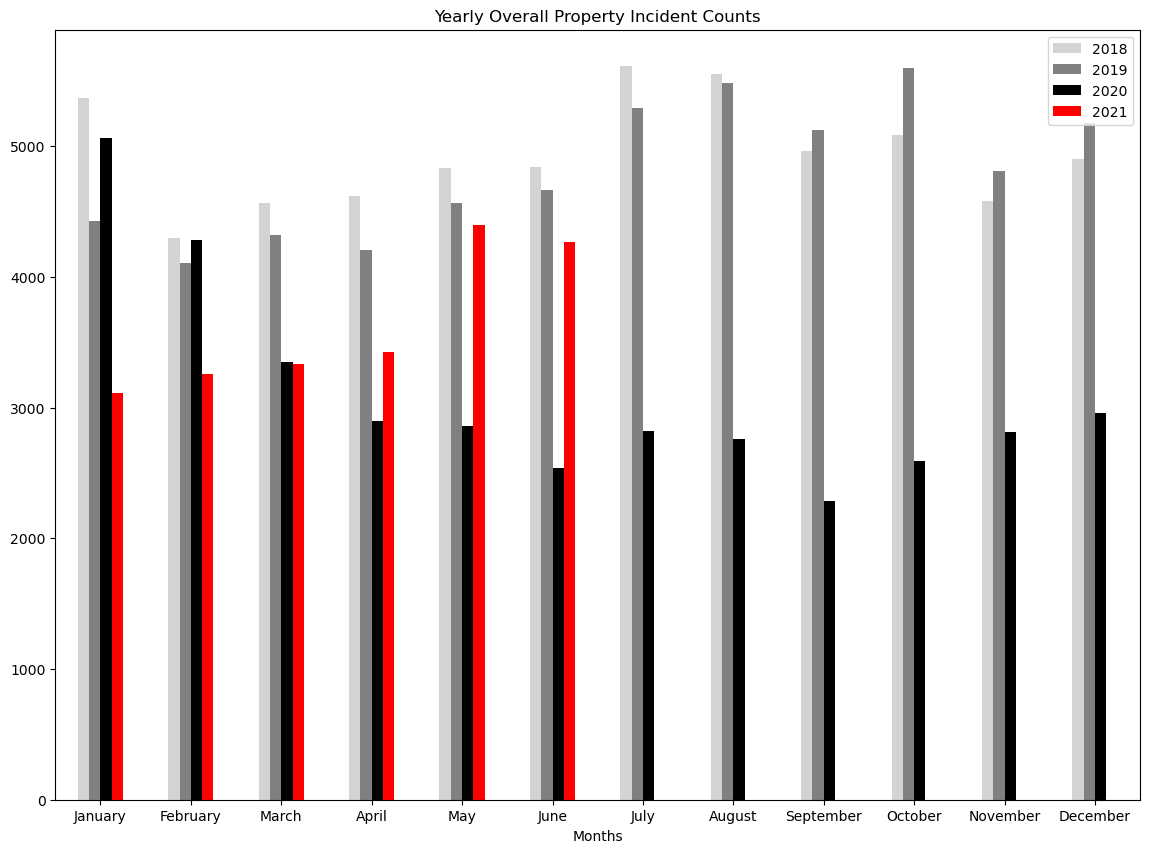

In [41]:
total_propertyincidents.plot(kind = 'bar', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], rot = 0)
plt.title('Yearly Overall Property Incident Counts')
plt.legend(loc = 'best');

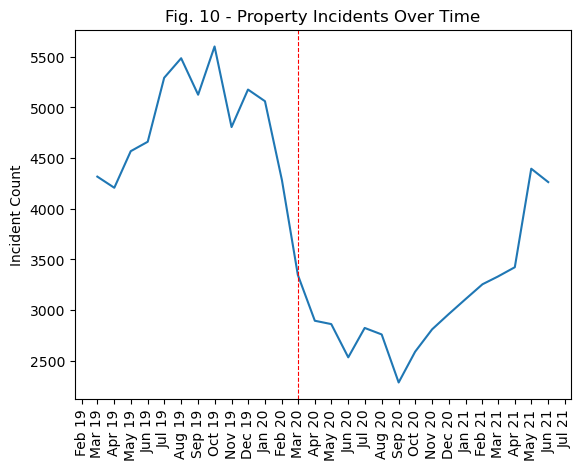

In [42]:
total_graph(propertyincidents, 'Fig. 10 - Property Incidents Over Time')

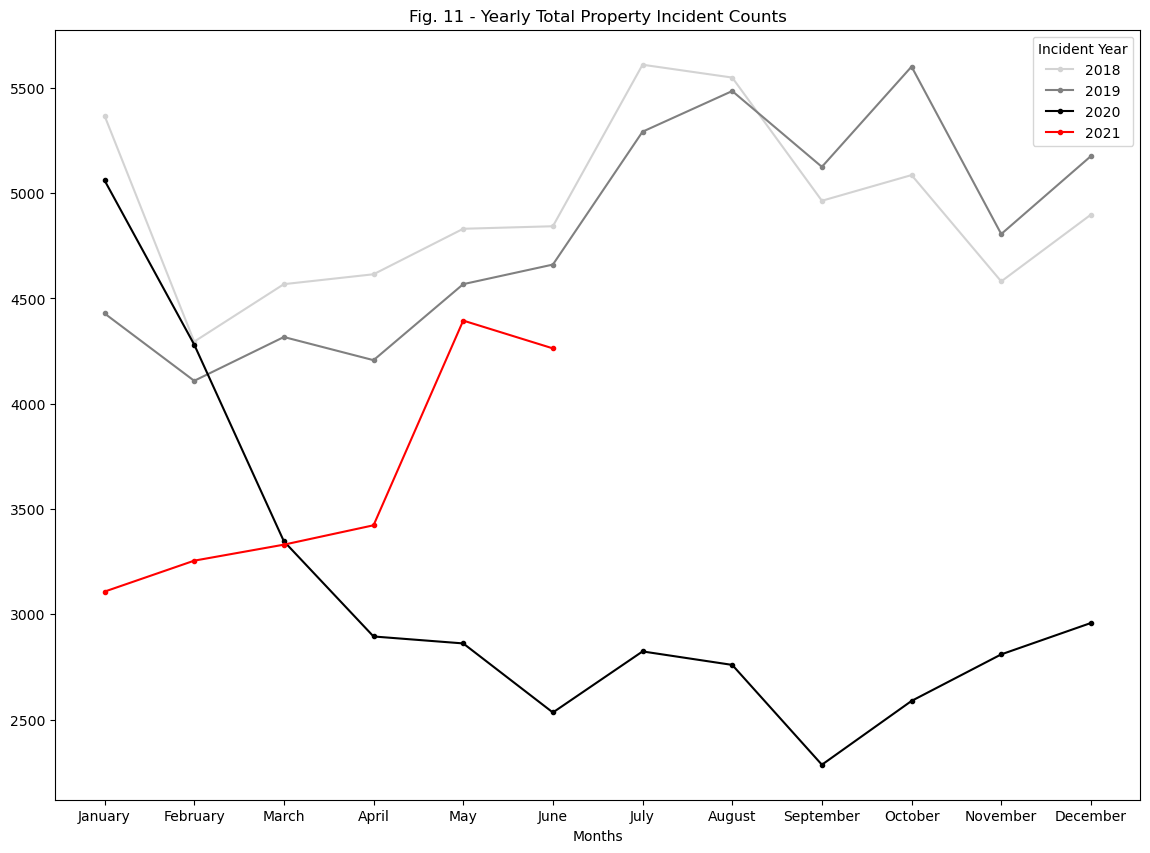

In [43]:
propertyline = total_propertyincidents.plot(kind = 'line', figsize = (14,10),color = ['lightgray', 'gray', 'black', 'red'], 
                            marker = '.',rot = 0)
propertyline.set_xticks(np.arange(0,12))
propertyline.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October','November', 'December'])
propertyline.set_title('Fig. 11 - Yearly Total Property Incident Counts');

In [44]:
incident_agg(propertyincidents)

Incident Year                    2018    2019    2020    2021
UCR_part_1          Months                                   
arson               January      24.0    24.0    23.0    32.0
                    February     25.0    18.0    21.0    34.0
                    March        28.0    19.0    29.0    36.0
                    April        34.0    22.0    36.0    37.0
                    May          20.0    24.0    30.0    27.0
                    June         30.0    17.0    29.0    36.0
                    July         22.0    22.0    27.0     NaN
                    August       35.0    30.0    41.0     NaN
                    September    18.0    32.0    22.0     NaN
                    October      39.0    33.0    22.0     NaN
                    November     43.0    34.0    19.0     NaN
                    December     24.0    20.0    29.0     NaN
burglary            January     602.0   514.0   573.0   783.0
                    February    531.0   460.0   493.0   775.0
                    March       583.0   521.0   508.0   681.0
                    April       581.0   486.0   720.0   650.0
                    May         630.0   530.0   836.0   673.0
                    June        562.0   421.0   590.0   649.0
                    July        627.0   535.0   652.0     NaN
                    August      698.0   522.0   596.0     NaN
                    September   585.0   454.0   527.0     NaN
                    October     542.0   489.0   568.0     NaN
                    November    480.0   489.0   546.0     NaN
                    December    511.0   503.0   702.0     NaN
larceny theft       January    4328.0  3478.0  3995.0  1698.0
                    February   3377.0  3235.0  3290.0  1833.0
                    March      3565.0  3367.0  2309.0  2033.0
                    April      3614.0  3262.0  1627.0  2169.0
                    May        3737.0  3573.0  1507.0  3037.0
                    June       3775.0  3770.0  1408.0  3001.0
                    July       4481.0  4284.0  1529.0     NaN
                    August     4378.0  4509.0  1643.0     NaN
                    September  3923.0  4161.0  1354.0     NaN
                    October    4013.0  4623.0  1509.0     NaN
                    November   3612.0  3794.0  1702.0     NaN
                    December   3909.0  4186.0  1666.0     NaN
motor vehicle theft January     414.0   413.0   470.0   595.0
                    February    362.0   396.0   477.0   613.0
                    March       392.0   410.0   501.0   581.0
                    April       386.0   437.0   512.0   567.0
                    May         444.0   441.0   489.0   658.0
                    June        476.0   453.0   507.0   577.0
                    July        480.0   451.0   616.0     NaN
                    August      438.0   424.0   480.0     NaN
                    September   438.0   478.0   383.0     NaN
                    October     492.0   456.0   490.0     NaN
                    November    446.0   489.0   543.0     NaN
                    December    454.0   467.0   562.0     NaN

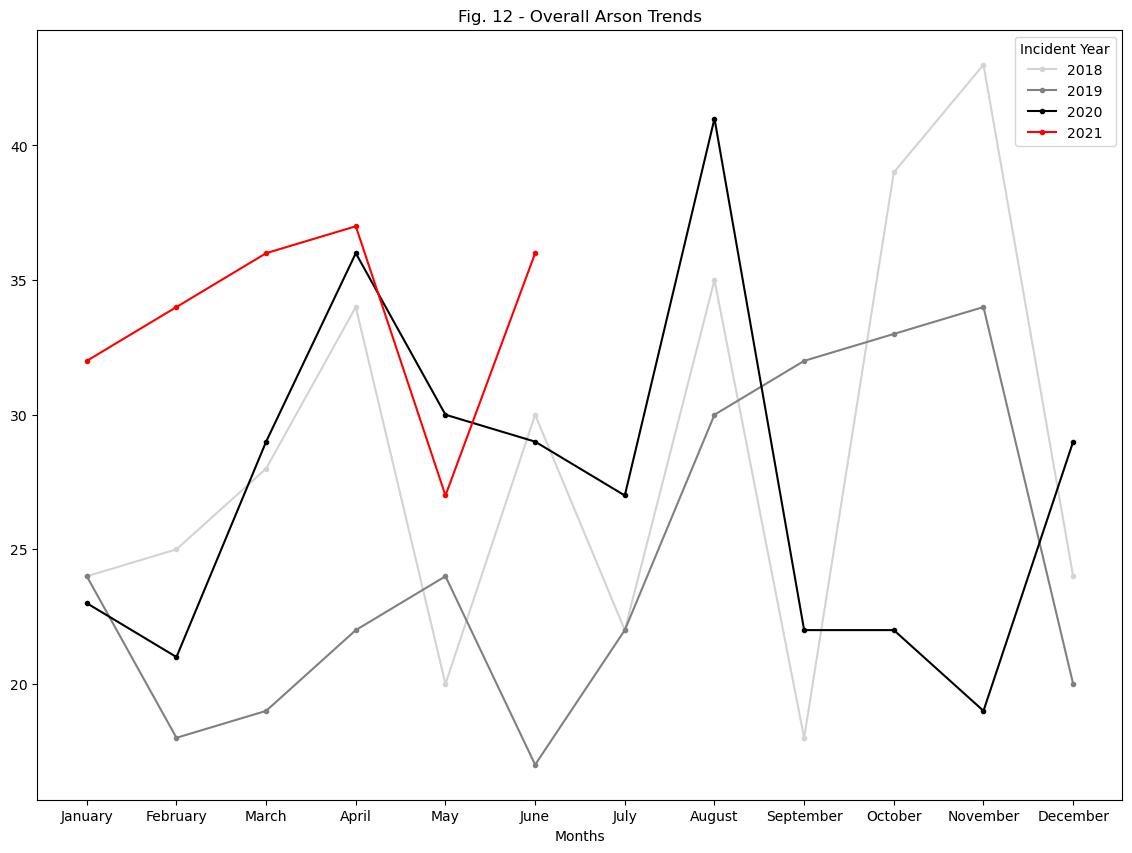

In [45]:
# arson trends 

incident_graph(propertyincidents, 'arson', 'Fig. 12 - Overall Arson Trends')

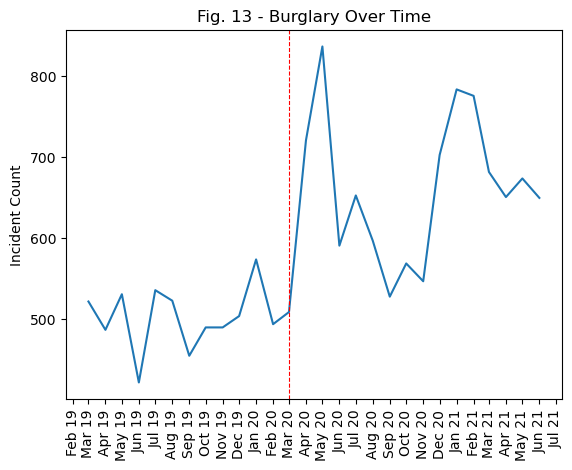

In [46]:
burglary_subset = total_incidents1[total_incidents1['UCR_part_1'] == 'burglary ']

total_graph(burglary_subset, 'Fig. 13 - Burglary Over Time')

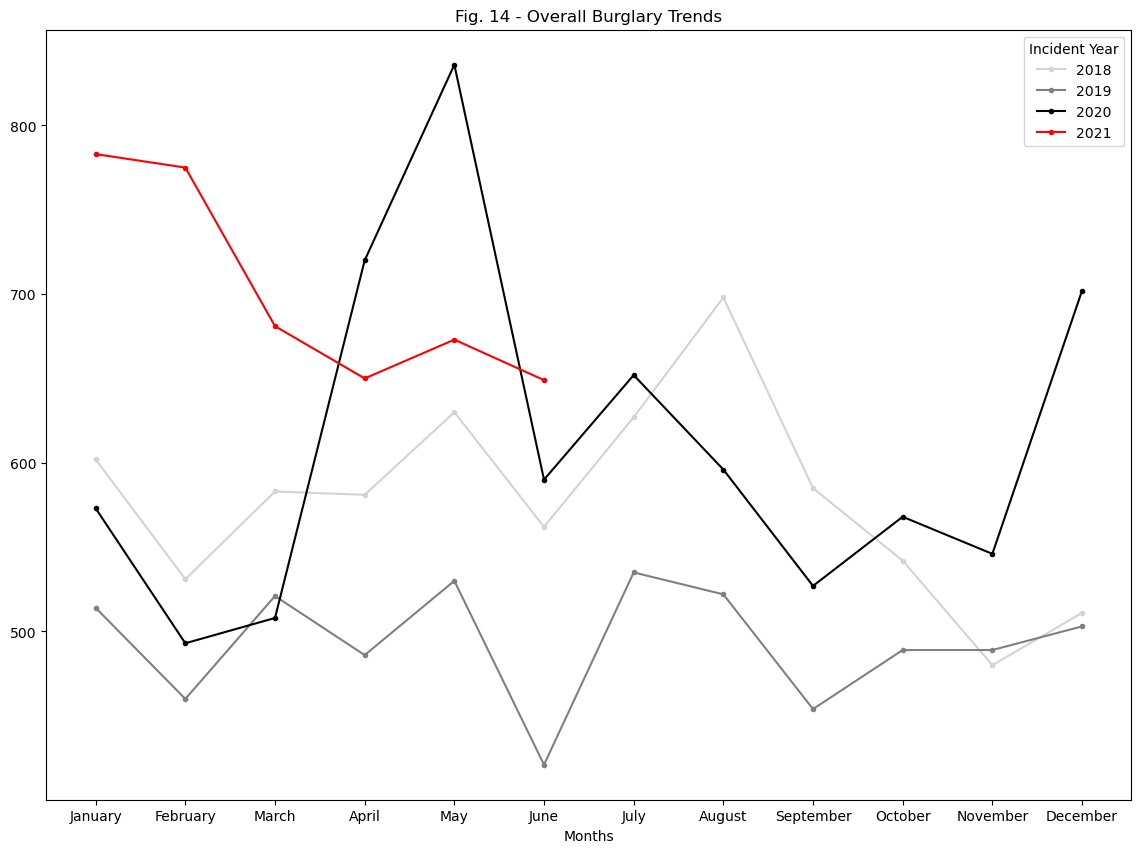

In [47]:
# burglary trends 

incident_graph(propertyincidents, 'burglary ', 'Fig. 14 - Overall Burglary Trends')

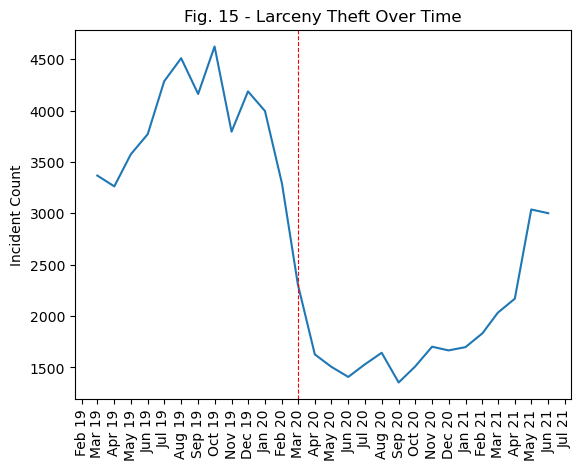

In [48]:
larceny_subset = total_incidents1[total_incidents1['UCR_part_1'] == 'larceny theft']

total_graph(larceny_subset, 'Fig. 15 - Larceny Theft Over Time')

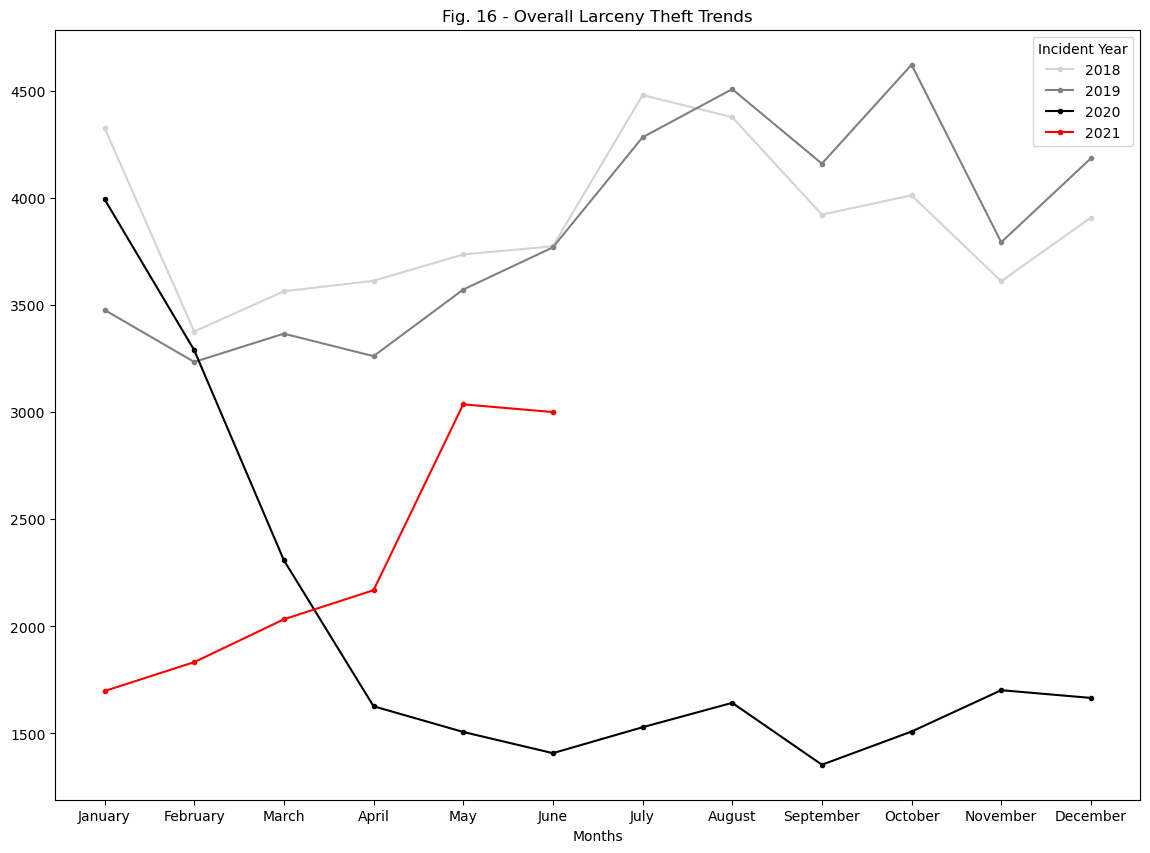

In [49]:
# larceny theft trends 

incident_graph(propertyincidents, 'larceny theft', 'Fig. 16 - Overall Larceny Theft Trends')

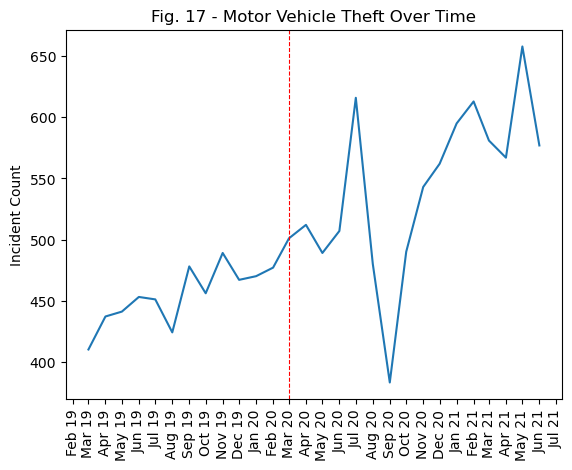

In [50]:
mtv_subset = total_incidents1[total_incidents1['UCR_part_1'] == 'motor vehicle theft']

total_graph(mtv_subset, 'Fig. 17 - Motor Vehicle Theft Over Time')

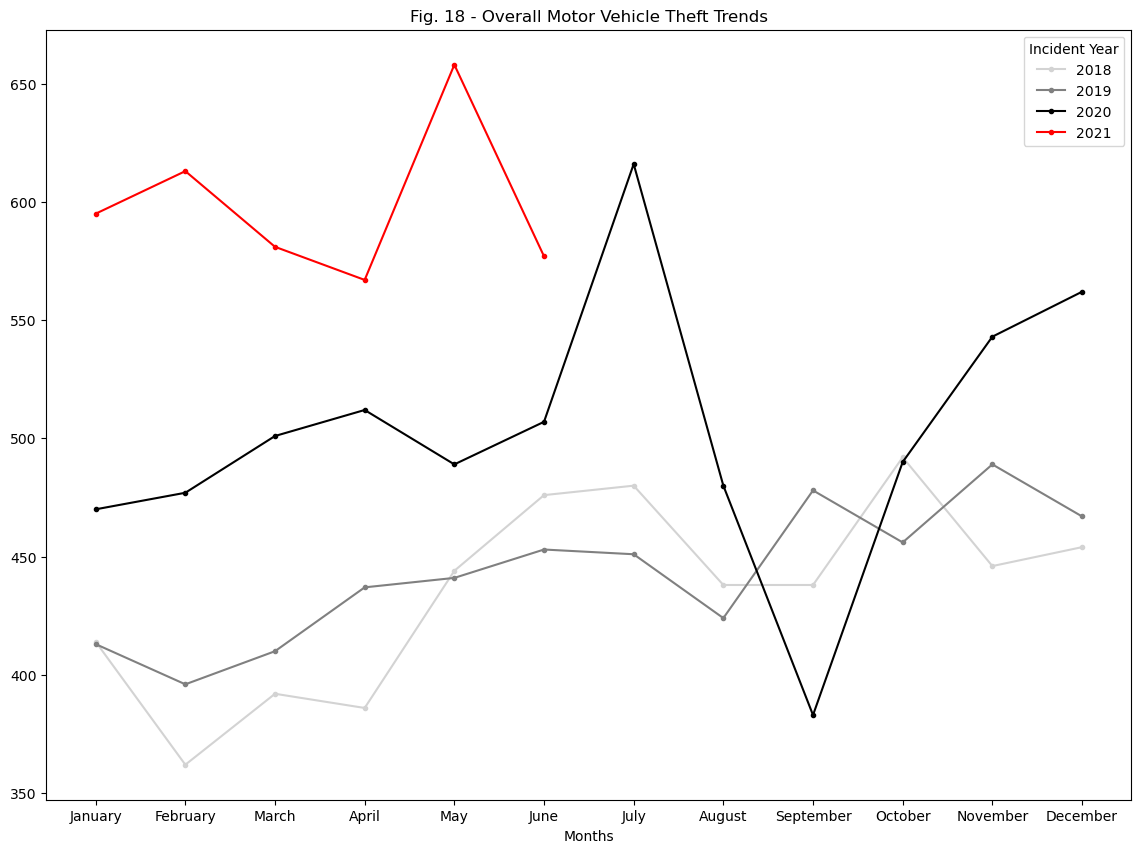

In [51]:
# motor vehicle theft trends 

incident_graph(propertyincidents, 'motor vehicle theft', 'Fig. 18 - Overall Motor Vehicle Theft Trends')

# Mapping

In [52]:
# reading in geometric map

sfmap = gpd.read_file('Analysis Neighborhoods.geojson')

In [53]:
# not useful for violent incidents as they are rare 

def heat_map(df, title):
    map = sns.heatmap(df, linewidths = .5, center = total_incidents.loc['March', 2020])
    map.set_title(title)

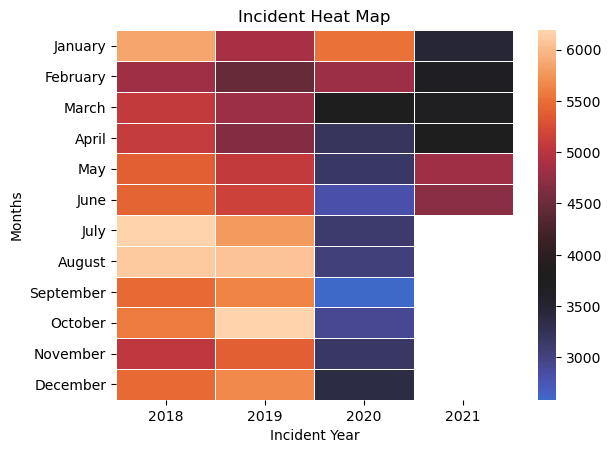

In [54]:
heat_map(total_incidents, 'Incident Heat Map')

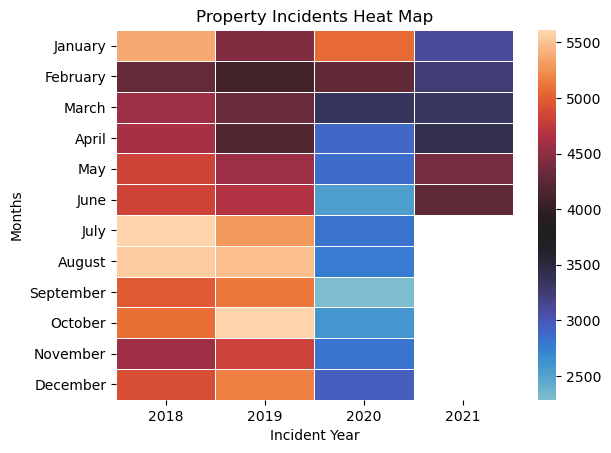

In [55]:
heat_map(total_propertyincidents, 'Property Incidents Heat Map')

In [61]:
# this function will illustrate the TOTAL incidents in DF it is used on

def shape_heattool1(df, title):
    
    n_data = pd.DataFrame(df.groupby('Analysis Neighborhood').agg('count')['Incident ID']).reset_index()
    n_data['Incident ID'] = n_data['Incident ID'].astype(float)
    new_df = sfmap.rename({'nhood': 'Analysis Neighborhood'}, axis = 1).merge(n_data, on = 'Analysis Neighborhood', how = 'left')
    
    fig, ax = plt.subplots(1, figsize = (10,10))
    ax.axis('off')
    ax.set_title(title, fontsize = 'large')
    color = 'Oranges'
    
    vmin = 0
    vmax = 8000
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=10)
    
    new_df.plot('Incident ID', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', vmin = vmin, vmax = vmax)
    
    for idx, row in new_df.iterrows():
        if (row['Incident ID'] >= 3000):
            plt.annotate(s=row['Analysis Neighborhood'], 
                     xy=row.geometry.centroid.coords[0],
                     horizontalalignment='center', 
                     fontsize='small', color='black', wrap=True)

C:\Users\simon\AppData\Local\Temp/ipykernel_12028/4182496667.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


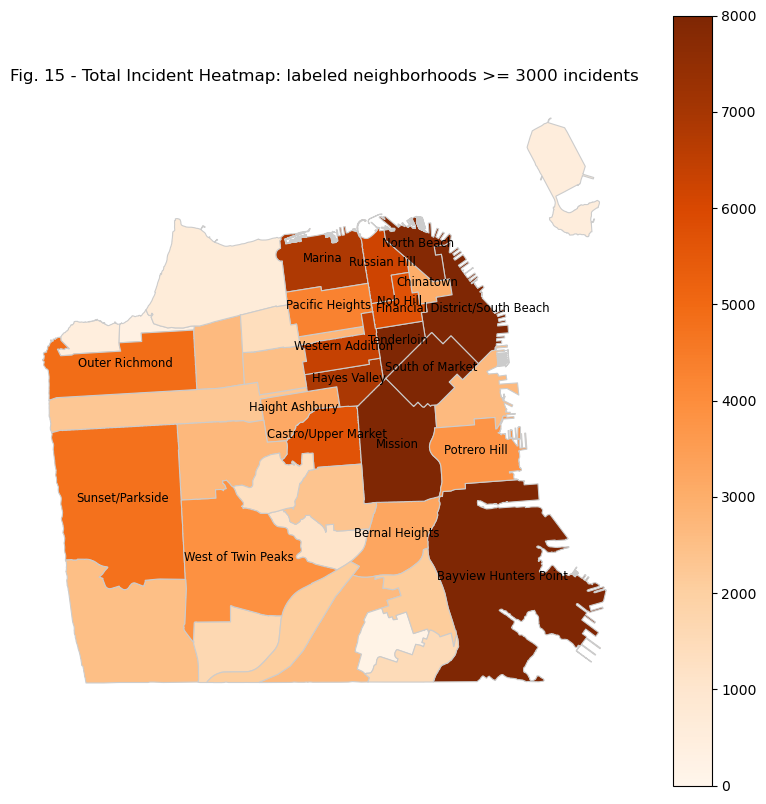

In [62]:
shape_heattool1(total_incidents1, 'Fig. 15 - Total Incident Heatmap: labeled neighborhoods >= 3000 incidents')

C:\Users\simon\AppData\Local\Temp/ipykernel_12028/4182496667.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


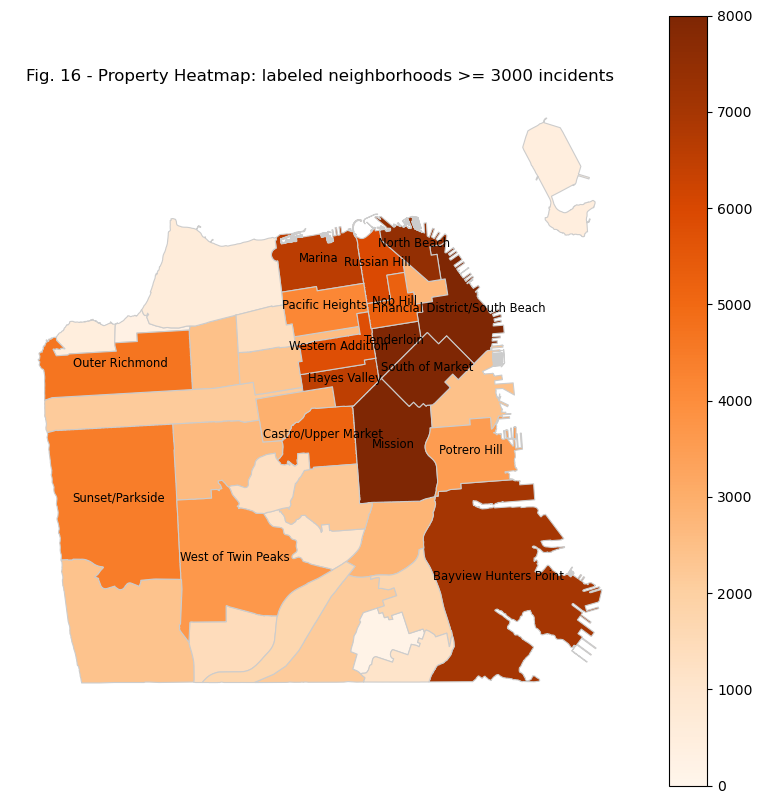

In [63]:
shape_heattool1(propertyincidents, 'Fig. 16 - Property Heatmap: labeled neighborhoods >= 3000 incidents')

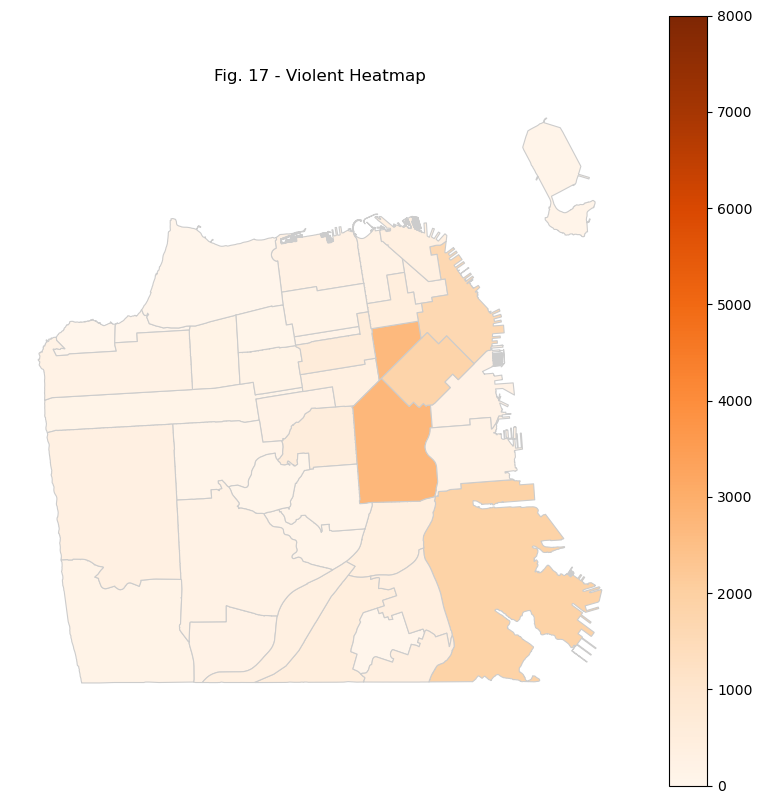

In [65]:
shape_heattool1(violentincidents, 'Fig. 17 - Violent Heatmap')

In [66]:
# total category over four years mapper

def category_mapper(df, itype, title):
    fig, ax = plt.subplots(figsize = (10,10))
    sfmap.plot(color = 'lightgrey', ax = ax)
    df = df[df['UCR_part_1'] == itype]
    df.plot(column = 'UCR_part_1', ax = ax, alpha = .05)
    plt.title(title)

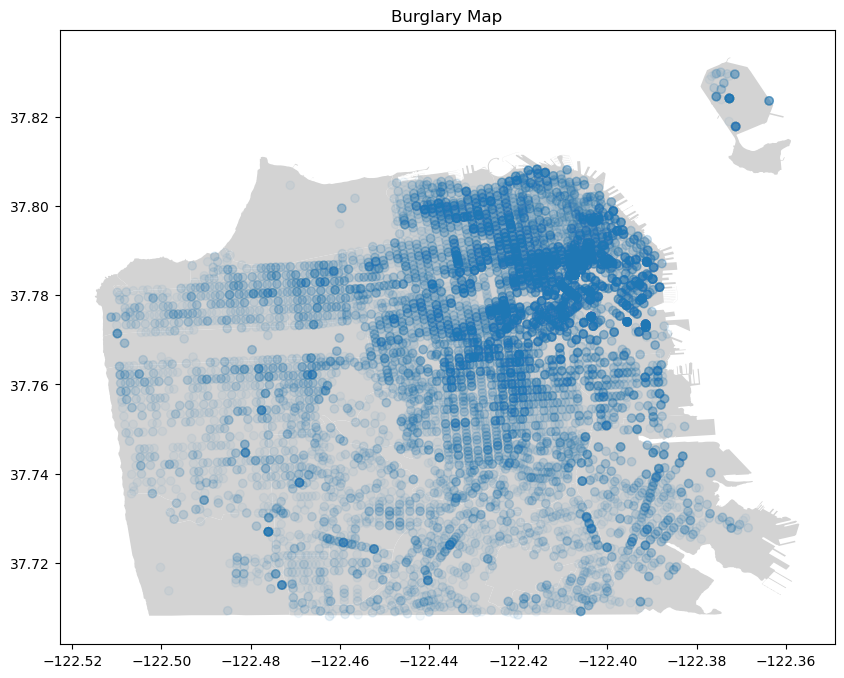

In [67]:
category_mapper(propertyincidents, 'burglary ', 'Burglary Map')

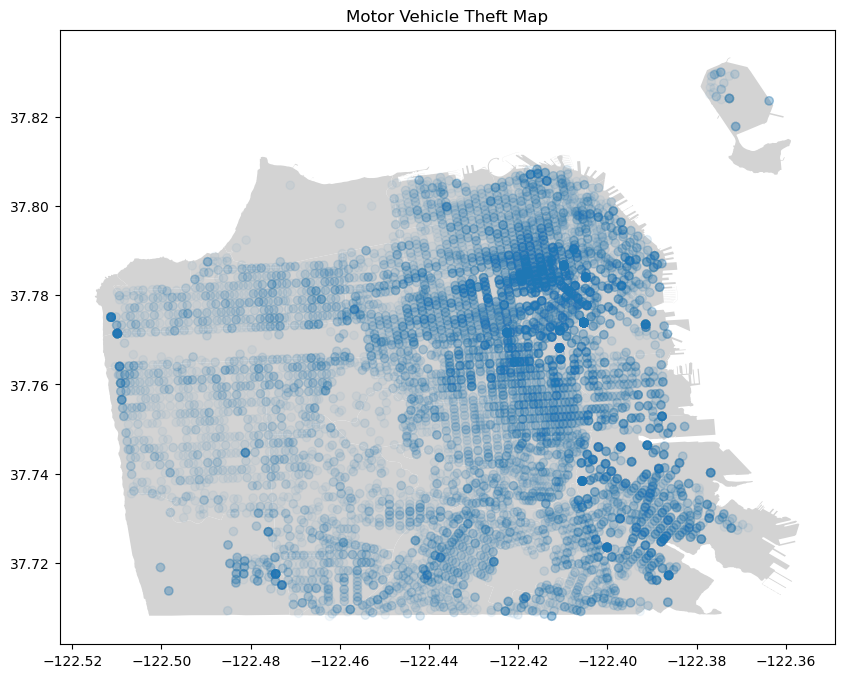

In [68]:
category_mapper(propertyincidents, 'motor vehicle theft', 'Motor Vehicle Theft Map')

# Pre- and Post-Pandemic Analysis

In [69]:
print(incident_report['Incident Date'].min())
print(incident_report['Incident Date'].max())

2018-01-01 00:00:00
2021-06-30 00:00:00


In [70]:
prepandemic = total_incidents1[(total_incidents1['Incident Date'] >= '2019-03-17') 
                                      & (total_incidents1['Incident Date'] < '2020-03-17')]

postpandemic = total_incidents1[(total_incidents1['Incident Date'] >= '2020-03-17') 
                                      & (total_incidents1['Incident Date'] <= '2021-03-17')]

In [107]:
64764 + 37943

102707

In [71]:
prepandemic.shape

(64764, 39)

In [72]:
postpandemic.shape

(37943, 39)

C:\Users\simon\AppData\Local\Temp/ipykernel_12028/4182496667.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


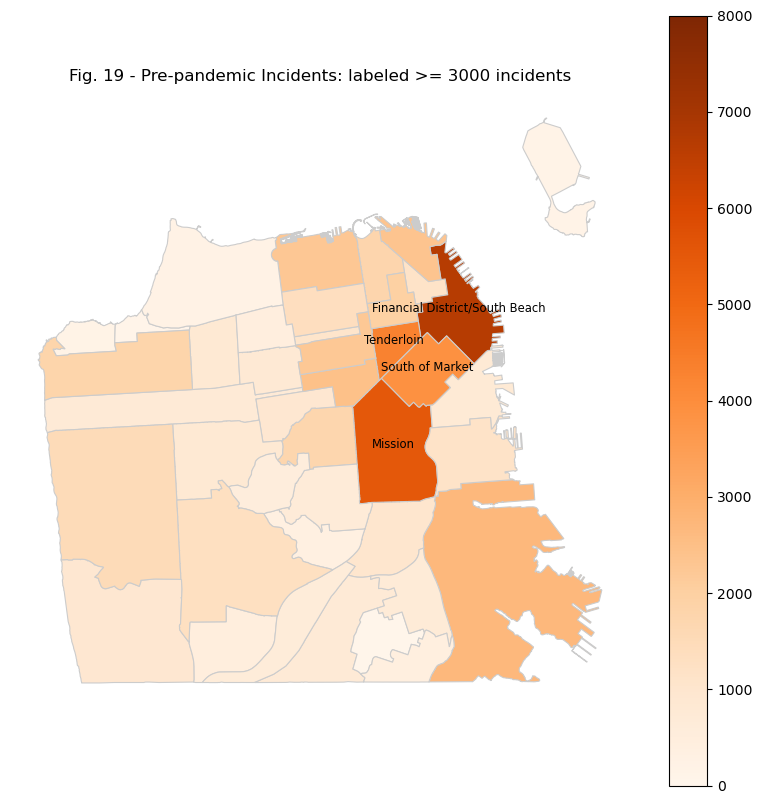

In [143]:
shape_heattool1(prepandemic, 'Fig. 19 - Pre-pandemic Incidents: labeled >= 3000 incidents')

C:\Users\simon\AppData\Local\Temp/ipykernel_12028/4182496667.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


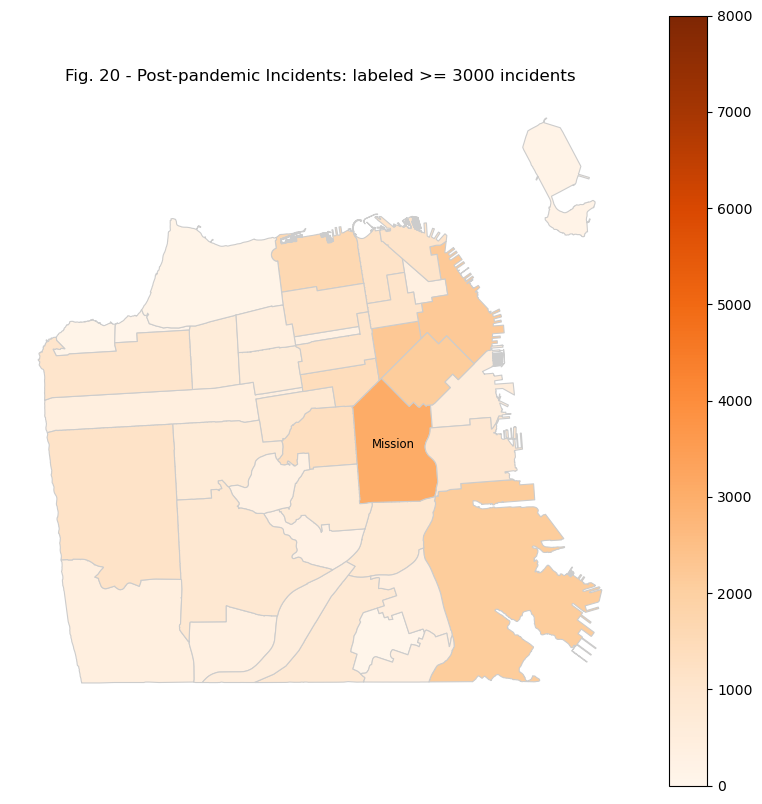

In [145]:
shape_heattool1(postpandemic, 'Fig. 20 - Post-pandemic Incidents: labeled >= 3000 incidents')

In [75]:
pd.DataFrame(prepandemic.groupby('Analysis Neighborhood').agg('size')).loc['Mission']

0    5529
Name: Mission, dtype: int64

In [76]:
# too many property incidents so the points overlap 

def pandemic_mapper(df, title):
    fig, ax = plt.subplots(1, figsize = (10,10))
    sfmap.plot(color = 'lightgrey', ax = ax)
    prepandemic = df[(df['Incident Date'] >= '2019-03-17') 
                          & (df['Incident Date'] < '2020-03-17')]
    pandemic = df[(df['Incident Date'] >= '2020-03-17') 
                  & (df['Incident Date'] <= '2021-03-17')]
    
    prepandemic.plot(ax = ax, alpha = .7)
    pandemic.plot(ax = ax, alpha = .7)
    plt.title(title)
    orange_patch = mpatches.Patch(color='orange', label='Pre-pandemic')
    blue_patch = mpatches.Patch(color='blue', label='Post-pandemic')
    plt.legend(handles=[orange_patch, blue_patch])
    ax.axis('off')

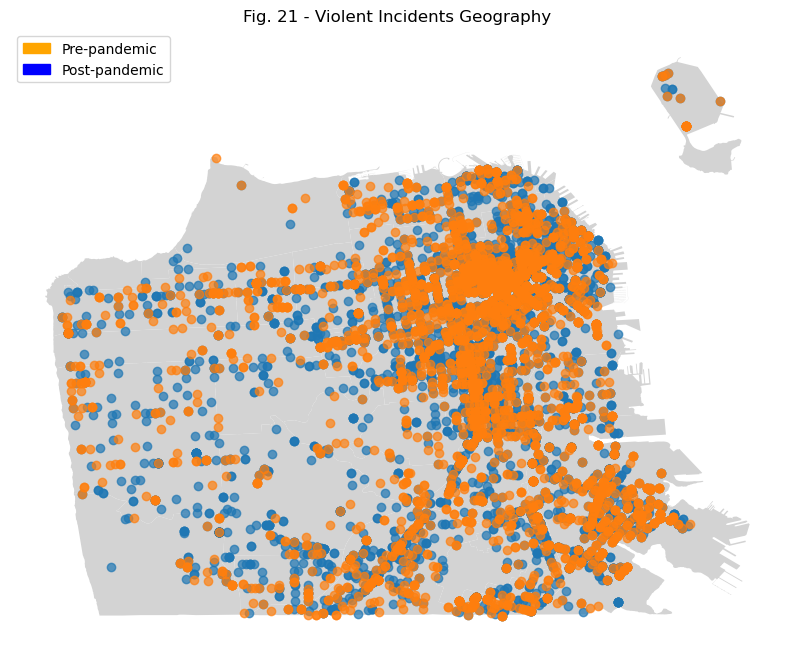

In [147]:
pandemic_mapper(violentincidents, 'Fig. 21 - Violent Incidents Geography')

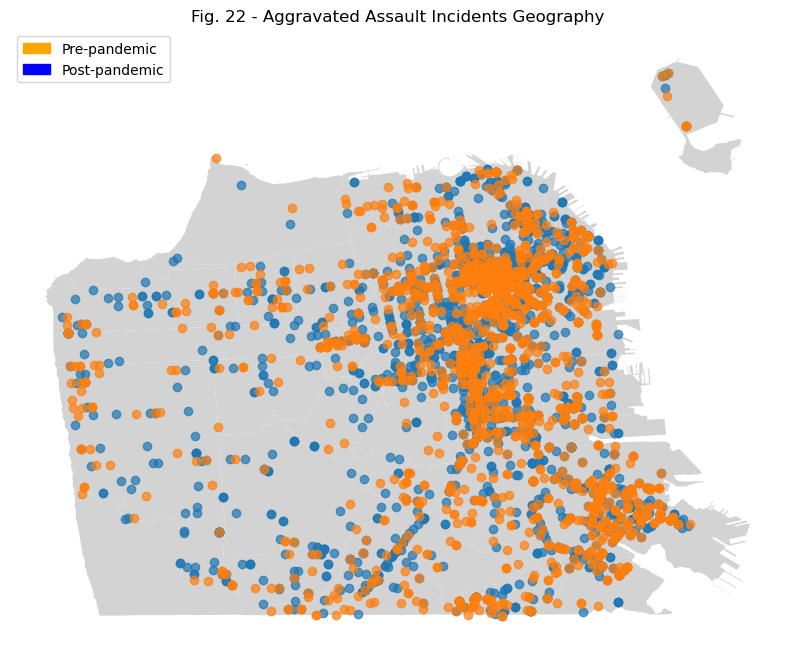

In [149]:
aggageo = filter_inrows_by_values(violentincidents, 'UCR_part_1', ['aggravated assault'])
pandemic_mapper(aggageo, 'Fig. 22 - Aggravated Assault Incidents Geography')

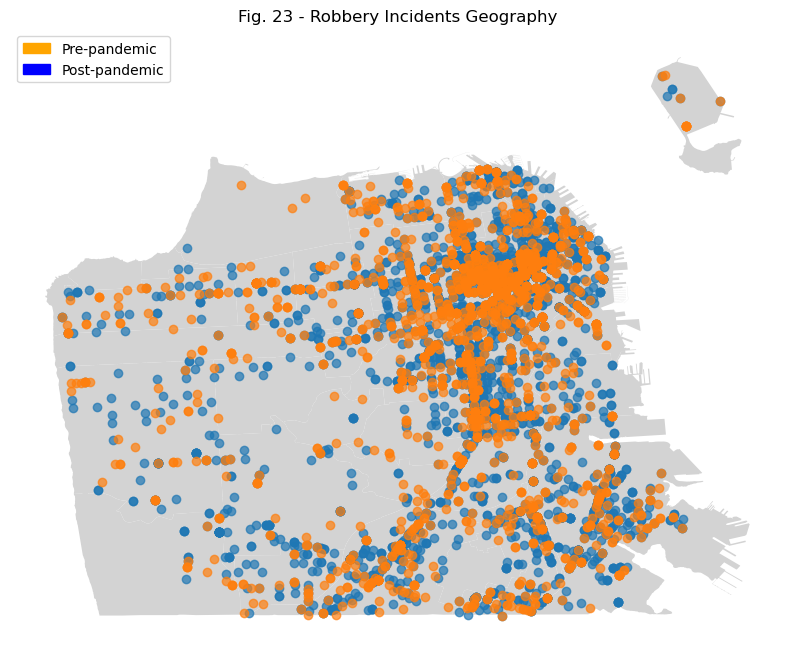

In [151]:
robberygeo = filter_inrows_by_values(violentincidents, 'UCR_part_1', ['robbery'])
pandemic_mapper(robberygeo, 'Fig. 23 - Robbery Incidents Geography')

In [80]:
# this function is for MTV

def shape_heattool2(df, title):
    
    n_data = pd.DataFrame(df.groupby('Analysis Neighborhood').agg('count')['Incident ID']).reset_index()
    n_data['Incident ID'] = n_data['Incident ID'].astype(float)
    new_df = sfmap.rename({'nhood': 'Analysis Neighborhood'}, axis = 1).merge(n_data, on = 'Analysis Neighborhood', how = 'left')
    
    fig, ax = plt.subplots(1, figsize = (10,10))
    ax.axis('off')
    ax.set_title(title, fontsize = 'large')
    color = 'Oranges'
    
    vmin = 0
    vmax = 800
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=10)
    
    new_df.plot('Incident ID', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', vmin = vmin, vmax = vmax)
    
    for idx, row in new_df.iterrows():
        if (row['Incident ID'] >= 200):
            plt.annotate(s=row['Analysis Neighborhood'], 
                     xy=row.geometry.centroid.coords[0],
                     horizontalalignment='center', 
                     fontsize='small', color='black', wrap=True)

In [161]:
postmtv.shape

(6346, 39)

C:\Users\simon\AppData\Local\Temp/ipykernel_12028/1328639393.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


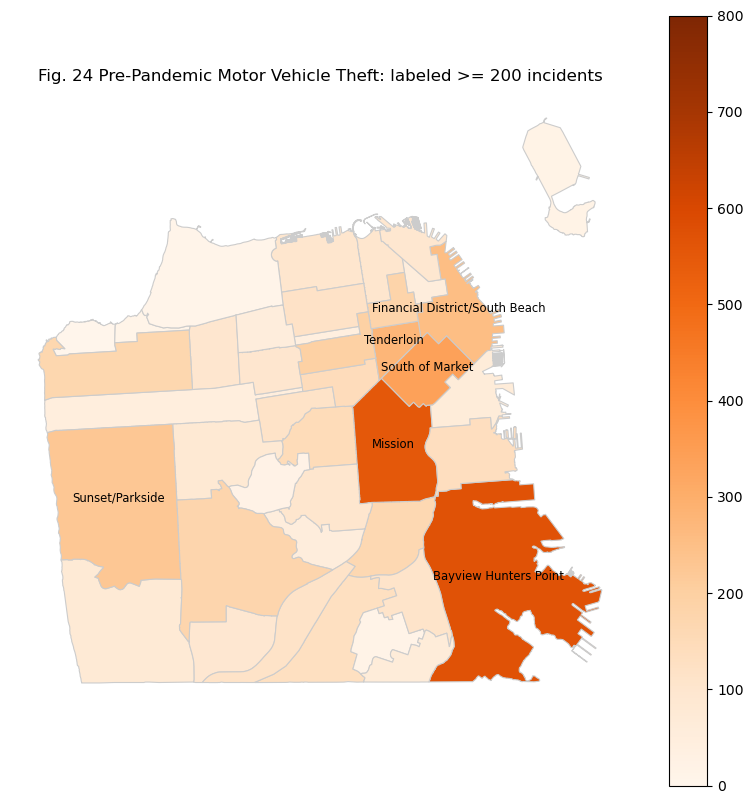

In [153]:
mtvgeo = filter_inrows_by_values(propertyincidents, 'UCR_part_1', ['motor vehicle theft'])

premtv = mtvgeo[(mtvgeo['Incident Date'] >= '2019-03-17') 
                                      & (mtvgeo['Incident Date'] < '2020-03-17')]

shape_heattool2(premtv, 'Fig. 24 Pre-Pandemic Motor Vehicle Theft: labeled >= 200 incidents')

In [82]:
premtv.groupby('Analysis Neighborhood').agg('size').max()

570

In [89]:
postmtv.groupby('Analysis Neighborhood').agg('size').max()

736

C:\Users\simon\AppData\Local\Temp/ipykernel_12028/1328639393.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


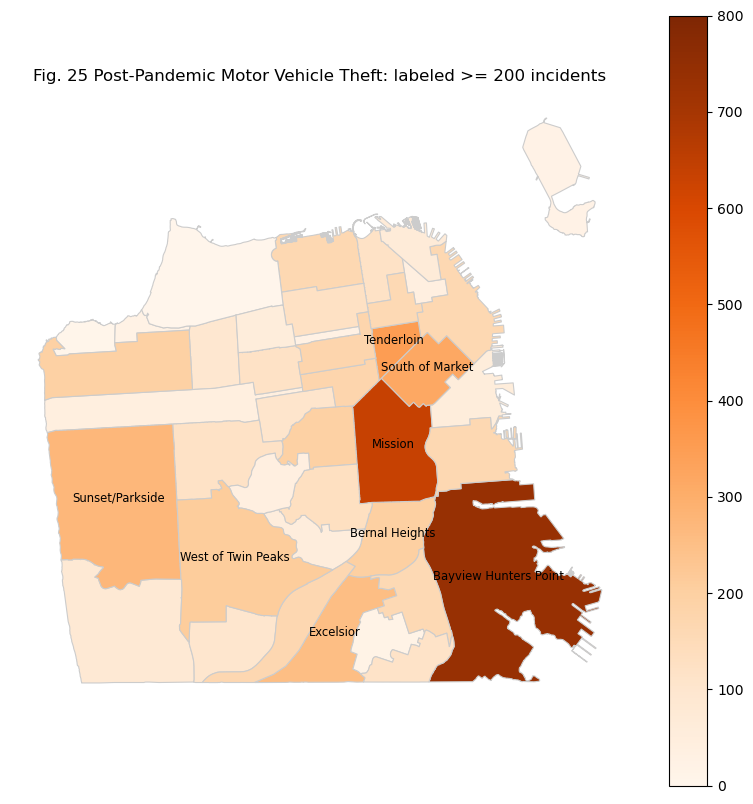

In [155]:
postmtv = mtvgeo[(mtvgeo['Incident Date'] >= '2020-03-17') 
                                      & (mtvgeo['Incident Date'] <= '2021-03-17')]

shape_heattool2(postmtv, 'Fig. 25 Post-Pandemic Motor Vehicle Theft: labeled >= 200 incidents')

In [85]:
print(premtv.shape)
print(postmtv.shape)

(5520, 39)
(6346, 39)


C:\Users\simon\AppData\Local\Temp/ipykernel_12028/1328639393.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


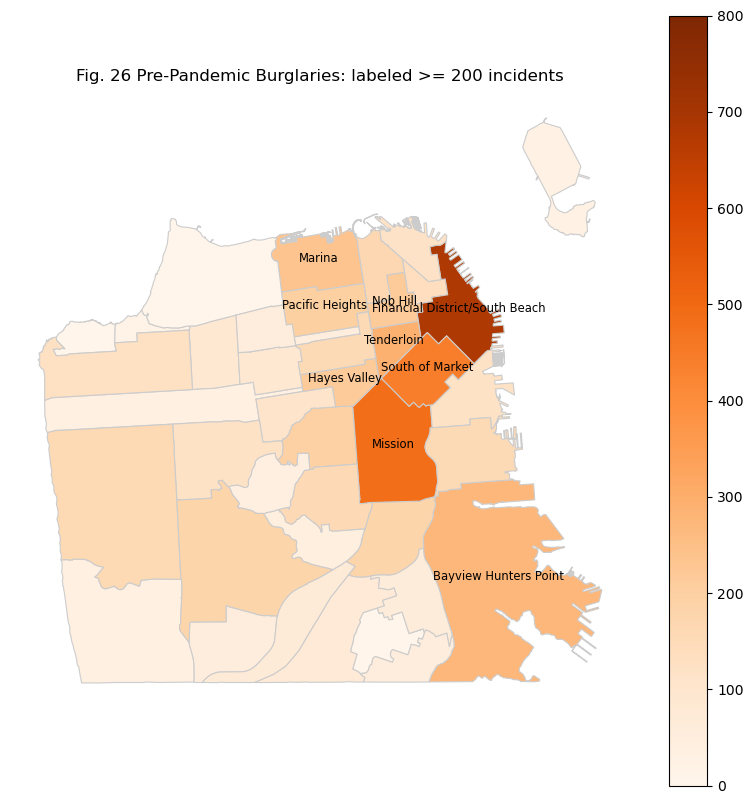

In [157]:
burglarygeo = filter_inrows_by_values(propertyincidents, 'UCR_part_1', ['burglary '])

preburglary = burglarygeo[(burglarygeo['Incident Date'] >= '2019-03-17') 
                                      & (burglarygeo['Incident Date'] < '2020-03-17')]

shape_heattool2(preburglary, 'Fig. 26 Pre-Pandemic Burglaries: labeled >= 200 incidents')

C:\Users\simon\AppData\Local\Temp/ipykernel_12028/1328639393.py:25: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=row['Analysis Neighborhood'],


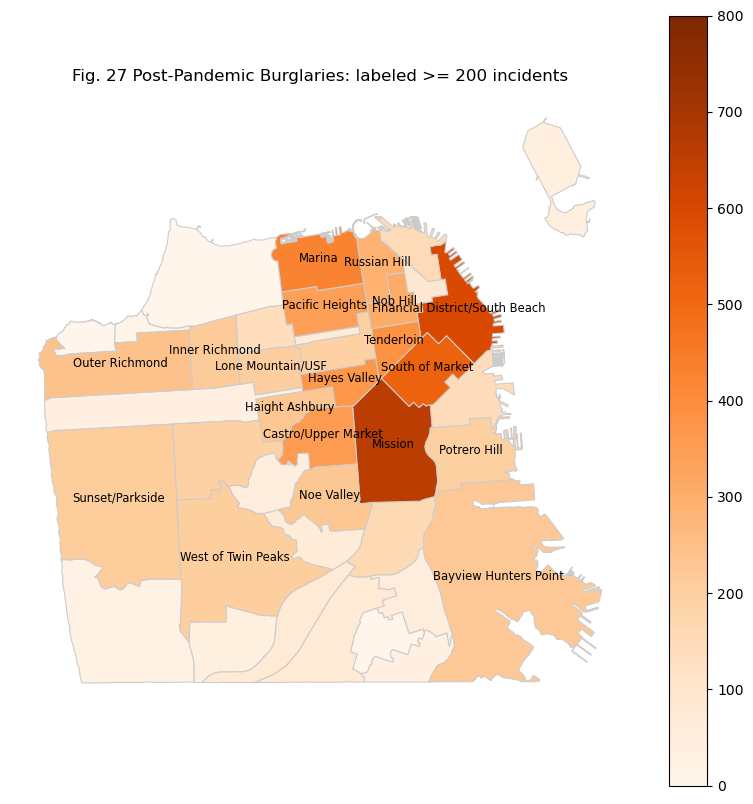

In [159]:
postburglary = burglarygeo[(burglarygeo['Incident Date'] >= '2020-03-17') 
                                      & (burglarygeo['Incident Date'] <= '2021-03-17')]

shape_heattool2(postburglary, 'Fig. 27 Post-Pandemic Burglaries: labeled >= 200 incidents')

In [88]:
print(preburglary.shape)
print(postburglary.shape)

(6018, 39)
(7952, 39)


In [162]:
preburglary.groupby('Analysis Neighborhood').agg('size')

Analysis Neighborhood
Bayview Hunters Point             273
Bernal Heights                    179
Castro/Upper Market               196
Chinatown                         136
Excelsior                          74
Financial District/South Beach    683
Glen Park                          43
Golden Gate Park                   36
Haight Ashbury                    112
Hayes Valley                      216
Inner Richmond                     89
Inner Sunset                      119
Japantown                          47
Lakeshore                          37
Lincoln Park                        2
Lone Mountain/USF                  86
Marina                            236
McLaren Park                        4
Mission                           487
Mission Bay                       120
Nob Hill                          216
Noe Valley                        158
North Beach                       116
Oceanview/Merced/Ingleside         54
Outer Mission                      69
Outer Richmond              

In [163]:
postburglary.groupby('Analysis Neighborhood').agg('size')

Analysis Neighborhood
Bayview Hunters Point             222
Bernal Heights                    161
Castro/Upper Market               354
Chinatown                          93
Excelsior                          76
Financial District/South Beach    595
Glen Park                          64
Golden Gate Park                   38
Haight Ashbury                    231
Hayes Valley                      366
Inner Richmond                    216
Inner Sunset                      199
Japantown                          64
Lakeshore                          29
Lincoln Park                        3
Lone Mountain/USF                 206
Marina                            427
McLaren Park                        3
Mission                           657
Mission Bay                       146
Nob Hill                          307
Noe Valley                        228
North Beach                       153
Oceanview/Merced/Ingleside         42
Outer Mission                      75
Outer Richmond              